In [132]:
start_x = 0
end_x = 500 # meters
T = 180     # seconds; upper bound 
t = [1:T;]
t_green_duration = 20  # seconds
t_red_duration = 24   # seconds, plus yellow time 4 seconds

# generating arrays for traffic light phases, assumption starts with red light 
t_g = Array{Int64}(T)
t_r = Array{Int64}(T)
for i=1:T
    j = i%(t_red_duration + t_green_duration)
    if j<=(t_red_duration-1)
        t_g[i] = t_red_duration - j + 1
        t_r[i] = 0
    else
        t_g[i] = 0
        t_r[i] = t_green_duration - j + t_red_duration
    end
end

idle_fuel = 0.1/3600  # gallon per second

min_v = 6 # m/s
max_v = 19

using JuMP, Gurobi

m = Model(solver=GurobiSolver(OutputFlag = 0))
@variable(m, x[1:T] >=0 )          # position at time t
@variable(m, v[1:T] <= max_v)      # velocity at time t
@variable(m, -5 <= a[1:T-1] <= 1)  # acceleration at time t 
@variable(m, obj_t[1:T])           # epigraph variable for fuel piecewise linear function 
@variable(m, w[1:T-1])
@variable(m, z_1[1:T], Bin)   # iff z1=1 then x[i] >= 965
@variable(m, z_2[1:T], Bin)   # iff z2=1 then x[i] <= 965
@variable(m, z_3[1:T], Bin)   # if z1=1 and z2=1 then z3 = 1; i.e. x[i] == 965
@variable(m, z_4[1:T], Bin)   # if x[i]<= 964.9 then z4 = 1
@variable(m, z_5[1:T], Bin)   # if x[i]>= 965.1 then z5 = 1
@variable(m, z_6[1:T], Bin)   # if z4=1 and z5 = 1 then z6=1; 
@variable(m, z_7[1:T], Bin)   # if x[i]>=946 then z7=1
@variable(m, z_8[1:T], Bin)   # if x[i]<=965 then z8=1
@variable(m, z_9[1:T], Bin)   # if z7=1 and z8=1 then z9=1
@variable(m, z_10[1:T], Bin)  # if v[i]<=0 then z_10 = 1


@constraint(m, dynamics[i in 1:T-1], x[i+1] == x[i] + a[i]/2 + v[i]) # per second, x = at^2*0.5 + vt
@constraint(m, velocity_change[i in 1:T-1], v[i+1] == v[i] + a[i])   # per second, v = v_initial + at 
@constraint(m, x[T] >= end_x)
@constraint(m, x[1] == start_x)
@constraint(m, v[1] == 0)
#@constraint(m, vel_min[i in 2:T-1], v[i] >= min_v)

# piecewise linear function for fuel 
@constraint(m, fuel_lin1[i in 1:T], obj_t[i] >= 0.00062*(-13/2*v[i]+59))
@constraint(m, fuel_lin2[i in 1:T], obj_t[i] >= 0.00062*7)
@constraint(m, fuel_lin3[i in 1:T], obj_t[i] >= 0.00062*(3/4*v[i]-17/4))

for i=1:T-1
    @constraint(m, w[i] >= a[i])
    @constraint(m, -w[i] <= a[i])
end

# Constraints for near the traffic light
for i=1:T
    @constraint(m, x[i] - (end_x-19) <= end_x*2*z_7[i] - 0.1*(1-z_7[i]))
    @constraint(m, x[i] - (end_x-19) >= -(end_x-19)*(1-z_7[i]))
    @constraint(m, x[i] - (end_x) >= -(end_x)*z_8[i] + 0.1(1-z_8[i]))
    @constraint(m, x[i] - (end_x) <= end_x*2*(1-z_8[i]))
    @constraint(m, z_7[i] + z_8[i] - 2 <= 2*z_9[i] - (1-z_9[i]))
    @constraint(m, z_7[i] + z_8[i] - 2 >= -2*(1-z_9[i]))
    
    @constraint(m, x[i]- end_x <= end_x*2*z_1[i] - (1-z_1[i]))  # constraints for checking if x[i]==end_x
    @constraint(m, x[i] - end_x >= -end_x*(1-z_1[i]))
    @constraint(m, x[i]- end_x >= -end_x*z_2[i] + (1-z_2[i]))
    @constraint(m, x[i]- end_x <= end_x*2*(1-z_2[i])) 
    @constraint(m, z_1[i] + z_2[i] - 2 <= 2*z_3[i] - (1-z_3[i]))
    @constraint(m, z_1[i] + z_2[i] - 2 >= -2*(1-z_3[i]))
        
    for j=i:i+t_g[i]
        
        if j<=T
            @constraint(m, x[j]-(end_x) <= 2*(end_x)*(1-z_9[i])) # if z9=1 then x[i+1] ... x[i+t_g[i]<=end_x
            @constraint(m, v[j] <= 19*(1-z_3[i]))                # if z3=1 then v[j] = 0, last speed =0 when stops
        end
    end
    
    if i>=2
        @constraint(m, v[i] >= -0.1*z_10[i]+(1-z_10[i]))
        @constraint(m, v[i] <= 19*(1-z_10[i]))
    end
end

# Objective function: 
# 1) minimize fuel only until traffic light (z_8=1 if x[i]<=965)
# 2) minimize change in velocities until traffic light 
# 3) idle time: sum all the cases when v[i]==0
#@NLobjective(m, Min,  sum(w[i]*z_8[i] for i in 1:(T-1)) + sum(z_10)*idle_fuel)
@objective(m, Min, sum(obj_t) + sum(w) + sum(z_10)*idle_fuel) 

solve(m)
vopt = getvalue(v)
xopt = getvalue(x)

println(getobjectivevalue(m))
println(sum(getvalue(a).^2))

index = 0 

for i in 1:T
    if xopt[i] >= (end_x-19) && xopt[i]<=end_x
        index = i
        println("t_g = ", t_g[index], " ",xopt[index], " ", i)
    end
   
end

println("z9:", getvalue(z_9))
println()
println(t_g)
println()
println(xopt)
println()
println("z10=", sum(getvalue(z_10)))
println()
println(vopt)

7.399971565217388
2.7866918714555817
t_g = 0 483.6782608695651 170
t_g = 0 486.56521739130426 171
t_g = 0 489.4521739130434 172
t_g = 0 492.3391304347826 173
t_g = 0 495.2260869565217 174
t_g = 0 498.11304347826086 175
z9:[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0]

[24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5

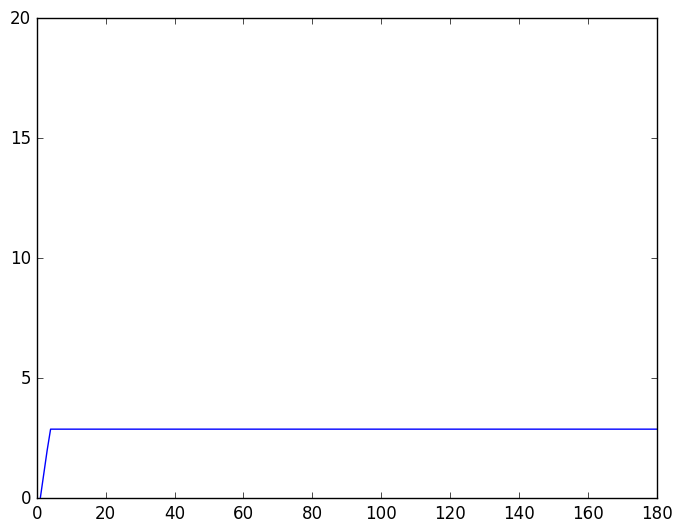

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32a921e10>

In [133]:
# For plotting velocity vs time (includes waiting time until green )
if xopt[T] == end_x
    x_plot = zeros(T + t_g[T])
    v_plot = zeros(T + t_g[T])
    t = [1:(T + t_g[T]);]
    for i in 1 : (T+t_g[T])
        if i<=T
            x_plot[i] = xopt[i]
            v_plot[i] = vopt[i]
        else 
            x_plot[i] = xopt[T]
            v_plot[i] = 0
        end
    end
else
    x_plot = xopt
    v_plot = vopt
    t = [1:T;]
end 
using PyPlot
ylim(0,20)
plot(t,v_plot)

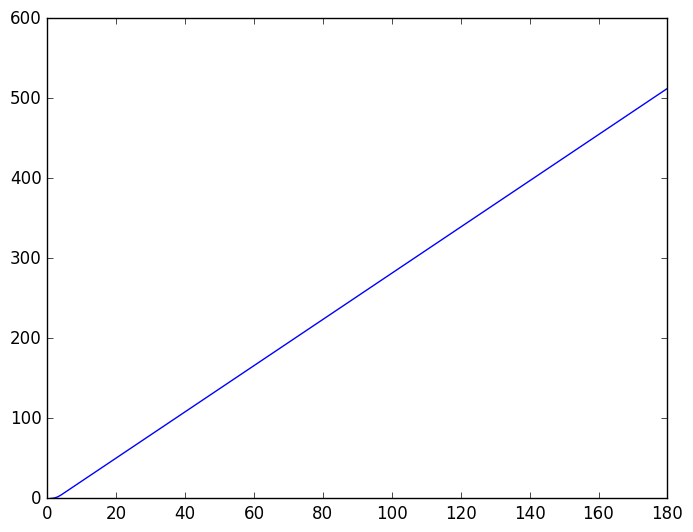

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x311fdd950>

In [134]:
# Plot of Position vs Time (includes waiting time's position)
ylim(0,end_x+100)
plot(t,x_plot)